# Notebook to analyse the results from hyperparameter search

In [1]:
# Import required libraries and initialize ray

import ray
from ray import tune
from ray.tune import ResultGrid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from functools import partial
import itertools
from run.main import train_with_args
from utils.general import load_config
ray.init()

2023-07-13 22:08:26,821	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


## 1. Collect results

In [2]:
# List the available trials in the ray_results directory

ray_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/ray_results/"
experiments = sorted([item.path for item in os.scandir(ray_results_dir) if item.is_dir()])
experiments

['/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_base_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_base_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_sessions23_b32',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_loss_sessions13',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_loss_sessions13_v2',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_model_sessions13',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_tokens_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_tokens_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/gpt_bslr',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/gpt_context3',
 '/Users/FrankVerhoef/Programming/PEX/output/

In [3]:
# Collect the results from all trials in one Pandas Dataframe

allresults_df = pd.DataFrame()
for exp in experiments:

    # Experiment name is last part of the path
    exp_name = exp.split('/')[-1]

    # Load the appropriate config file to 'reconstruct' the trainable
    baseconfig = load_config(exp + '/base.config')
    restored_tuner = tune.Tuner.restore(exp, trainable=partial(train_with_args, baseconfig))

    # Get the resultgrid for the experiment and append results to dataframe
    result_grid = restored_tuner.get_results()
    df = result_grid.get_dataframe()
    df['experiment_name'] = exp_name
    allresults_df = pd.concat([allresults_df, df], axis=0)

print(f"Collected information about {len(allresults_df)} trials")

2023-07-13 22:08:30,088	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-07-13 22:08:30,094	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-07-13 22:08:30,246	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` ob

Collected information about 493 trials


In [4]:
# Show info about available data columns

allresults_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 49
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   valid_loss                  493 non-null    float64
 1   valid_classification_loss   338 non-null    float64
 2   valid_lm_loss               338 non-null    float64
 3   valid_acc                   493 non-null    float64
 4   valid_perplexity            493 non-null    float64
 5   valid_token_prediction_acc  338 non-null    float64
 6   time_this_iter_s            493 non-null    float64
 7   done                        493 non-null    bool   
 8   timesteps_total             4 non-null      float64
 9   episodes_total              4 non-null      float64
 10  training_iteration          493 non-null    int64  
 11  trial_id                    493 non-null    object 
 12  experiment_id               493 non-null    object 
 13  date                        493 non-

In [5]:
# Show which fields have been used as config parameter in ray tune, and which metrics have been reported

grouplist = [col for col in allresults_df.columns if col[:6] == 'config']
metriclist = [col for col in allresults_df.columns if col[:6] == 'valid_' or col[:5] == 'test_' or col[:5] == 'eval_']
grouplist, metriclist

(['config/batch_size',
  'config/learning_rate',
  'config/seed',
  'config/len_context',
  'config/clf_loss',
  'config/lm_loss_factor',
  'config/sessions',
  'config/bart_base',
  'config/add_tokens',
  'config/nofact_token',
  'config/speaker_prefixes',
  'config/context_option',
  'config/include_history',
  'config/include_persona',
  'config/persona_selector',
  'config/sessionbreak_token',
  'config/token_option'],
 ['valid_loss',
  'valid_classification_loss',
  'valid_lm_loss',
  'valid_acc',
  'valid_perplexity',
  'valid_token_prediction_acc'])

In [6]:
allresults_df[grouplist + metriclist].head()

,config/batch_size,config/learning_rate,config/seed,config/len_context,config/clf_loss,config/lm_loss_factor,config/sessions,config/bart_base,config/add_tokens,config/nofact_token,...,config/include_persona,config/persona_selector,config/sessionbreak_token,config/token_option,valid_loss,valid_classification_loss,valid_lm_loss,valid_acc,valid_perplexity,valid_token_prediction_acc
0,16.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.545417,3.080283,0.545417,0.674000,3.533215,0.655164
1,32.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.488318,2.984720,0.488318,0.674603,3.509900,0.655407
2,64.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.443452,3.006948,0.443452,0.675781,3.446414,0.658642
3,16.0,0.000010,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.508394,2.947887,0.508394,0.674000,3.262860,0.667981
4,32.0,0.000010,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.456625,2.995762,0.456625,0.674603,3.243120,0.671777


In [7]:
# Example of grouped results

allresults_df.groupby(by=['config/bart_base'])[metriclist].mean()

,valid_loss,valid_classification_loss,valid_lm_loss,valid_acc,valid_perplexity,valid_token_prediction_acc
config/bart_base,,,,,,
ainize/bart-base-cnn,0.394922,0.822377,0.394922,0.809180,3.331352,0.709608
facebook/bart-base,0.394063,0.877389,0.394063,0.774609,3.316189,0.703634
facebook/bart-large,0.400156,1.629527,0.400156,0.711816,3.355077,0.638903
facebook/bart-large-cnn,0.420592,3.149880,0.420592,0.663477,3.564538,0.656694
facebook/bart-large-xsum,0.417046,2.538384,0.417046,0.664795,3.528988,0.647956
lidiya/bart-large-xsum-samsum,0.437260,3.634270,0.437260,0.662744,3.749263,0.657892
philschmid/bart-large-cnn-samsum,0.427552,3.512193,0.427552,0.662744,3.629262,0.660384


## 2. Overview of results, per experiment for BART

### Analyse impact of batch_size, learning_rate

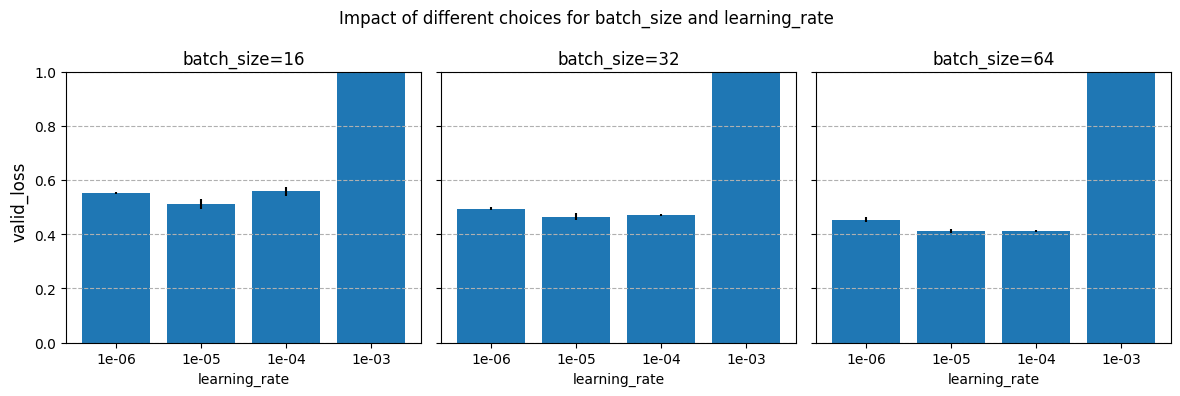

In [8]:
# Analyze impact of batch_size and learning_rate in session 1, or session 2 and 3
# Plot subplots per batch_size

# Uncomment one of the following lines
expnames = ['bart_base_session1']
# expnames = ['bart_base_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

batch_sizes = df['config/batch_size'].unique()
fig, ax = plt.subplots(ncols=len(batch_sizes), figsize=(12, 4), sharey=True)

for i, batch_size in enumerate(batch_sizes):
    selection = (df["config/batch_size"] == batch_size) # & (df["config/learning_rate"] != 1e-3)
    result_df = df[selection].groupby(['config/learning_rate']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    x_values = [f"{x:.0e}" for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)
    ax[i].set_title(f"batch_size={int(batch_size):d}")
    ax[i].set_xlabel("learning_rate")
    if i==0:
        ax[i].set_ylim(0,1)
    ax[i].grid(which='major', axis='y', linestyle='--')

fig.suptitle("Impact of different choices for batch_size and learning_rate")
fig.supylabel("valid_loss")
fig.tight_layout()

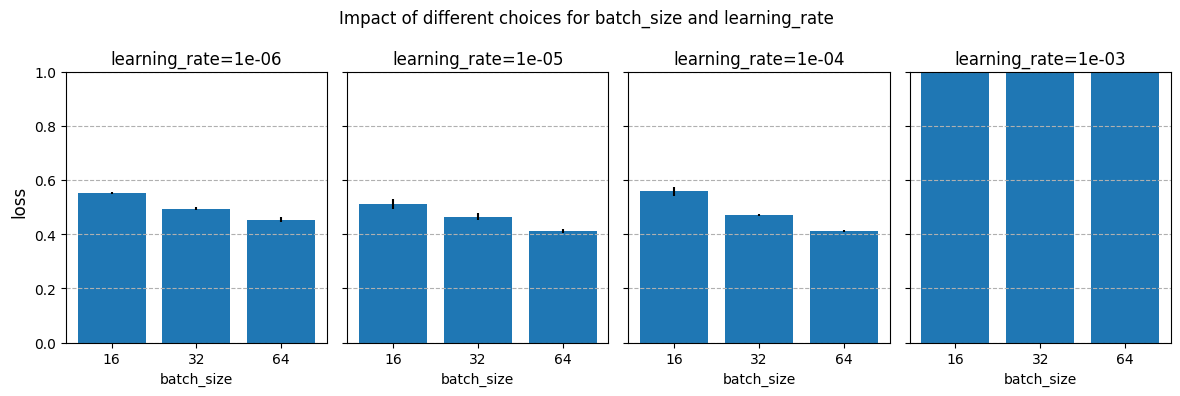

In [9]:
# Analyze impact of batch_size and learning_rate in session 1, or session 2 and 3
# Plot subplots per learning_rate

# Uncomment one of the following lines
expnames = ['bart_base_session1']
# expnames = ['bart_base_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

learning_rates = df['config/learning_rate'].unique()
fig, ax = plt.subplots(ncols=len(learning_rates), figsize=(12, 4), sharey=True)

for i, learning_rate in enumerate(learning_rates):
    selection = (df["config/learning_rate"] == learning_rate)
    result_df = df[selection].groupby(['config/batch_size']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    x_values = [f"{int(x):d}" for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)
    ax[i].set_title(f"learning_rate={learning_rate:.0e}")
    ax[i].set_xlabel("batch_size")
    if i==0:
        ax[i].set_ylim(0,1)
    ax[i].grid(which='major', axis='y', linestyle='--')
    
fig.suptitle("Impact of different choices for batch_size and learning_rate")
fig.supylabel("loss")
fig.tight_layout()

### Analyse impact of speaker_prefixes, nofact_token, add_tokens

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/1682238114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/1682238114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]


size of sample:  8
size of sample:  2
size of sample:  6


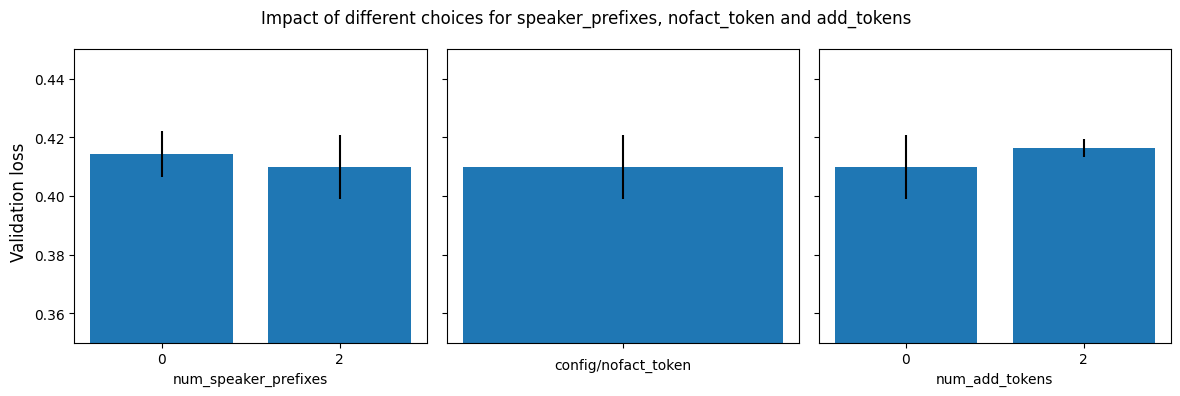

In [10]:

# Uncomment one of the following lines
expnames = ['bart_tokens_session1']
# expnames = ['bart_tokens_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

# Adjust labels for better plots
df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]

grouplist = ['num_speaker_prefixes', 'config/nofact_token', 'num_add_tokens']
base_selection = {
    'num_speaker_prefixes': (df['config/nofact_token'] == '') &(df['num_add_tokens'] == 0),
    'config/nofact_token': (df['num_speaker_prefixes'] == 2) & (df['num_add_tokens'] == 0),
    'num_add_tokens': (df['config/nofact_token'] == '') & (df['num_speaker_prefixes'] == 2)
}
titles = []
fig, ax = plt.subplots(ncols=len(grouplist), figsize=(12,4), sharey=True)

for i, grp in enumerate(grouplist):

    print("size of sample: ", len(df[base_selection[grp]]))
    result_df = df[base_selection[grp]][[grp] + ['valid_loss']].groupby(grp).agg(['mean', 'std'])
    # result_df = df[[grp] + ['valid_loss']].groupby(grp).agg(['mean', 'std'])

    x_values = [str(x) for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df[('valid_loss', 'mean')].values, yerr=result_df[('valid_loss', 'std')])

    ax[i].set_xlabel(grp)
    if i == 0:
        ax[i].set_ylim(0.35, 0.45)

fig.suptitle("Impact of different choices for speaker_prefixes, nofact_token and add_tokens")
fig.supylabel("Validation loss")
fig.tight_layout()

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/784018177.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/784018177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]


size of sample:  17
[0 1]
[0 1]
size of sample:  24
[0 1]
[0 1]
size of sample:  24
[0 1 2 3]
[0 1 2 3]


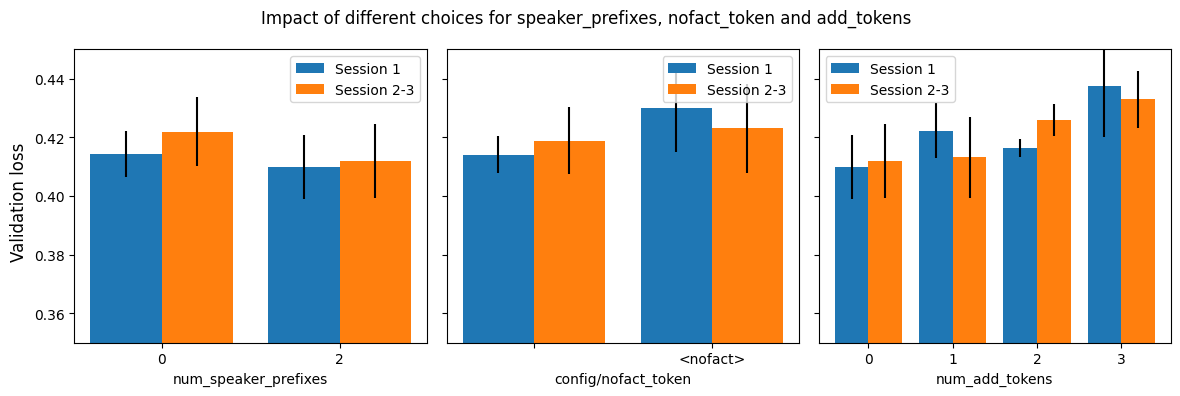

In [29]:

expnames = ['bart_tokens_session1', 'bart_tokens_sessions23']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

# Adjust labels for better plots
df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]

grouplist = ['num_speaker_prefixes', 'config/nofact_token', 'num_add_tokens']
base_selection = {
    'num_speaker_prefixes': (df['config/nofact_token'] == '') &(df['num_add_tokens'] == 0),
    'config/nofact_token': (df['num_speaker_prefixes'] == 2), 
    'num_add_tokens': (df['num_speaker_prefixes'] == 2)
}
titles = []
labels = {
    'bart_tokens_session1': 'Session 1',
    'bart_tokens_sessions23': 'Session 2-3'
}
fig, ax = plt.subplots(ncols=len(grouplist), figsize=(12,4), sharey=True)

for i, grp in enumerate(grouplist):

    print("size of sample: ", len(df[base_selection[grp]]))

    for j, expname in enumerate(expnames):
        subselection = df['experiment_name'] == expname
        result_df = df[base_selection[grp] & subselection][[grp] + ['valid_loss']].groupby(grp).agg(['mean', 'std'])
        # result_df = df[subselection][[grp] + ['valid_loss']].groupby(grp).agg(['mean', 'std'])

        x_values = np.arange(len(result_df.index))
        print(x_values)
        ax[i].bar(x=x_values-0.2+0.4*j, height=result_df[('valid_loss', 'mean')].values, width=0.4, yerr=result_df[('valid_loss', 'std')], label=labels[expname])

    ax[i].set_xlabel(grp)
    ax[i].set_xticks(x_values)
    ax[i].set_xticklabels(([str(x) for x in result_df.index]))
    ax[i].legend()
    if i == 0:
        ax[i].set_ylim(0.35, 0.45)

fig.suptitle("Impact of different choices for speaker_prefixes, nofact_token and add_tokens")
fig.supylabel("Validation loss")
fig.tight_layout()

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/64050394.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_45078/64050394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]


size of sample:  17
config/speaker_prefixes
['None', "['<other>', '<self>']"]
size of sample:  24
config/nofact_token
['<eos> token', "'<nofact>'"]
size of sample:  24
config/add_tokens
['[]', "['<nofact>']", "['<other>', '<self>']", "['<other>', '<self>', '<nofact>']"]


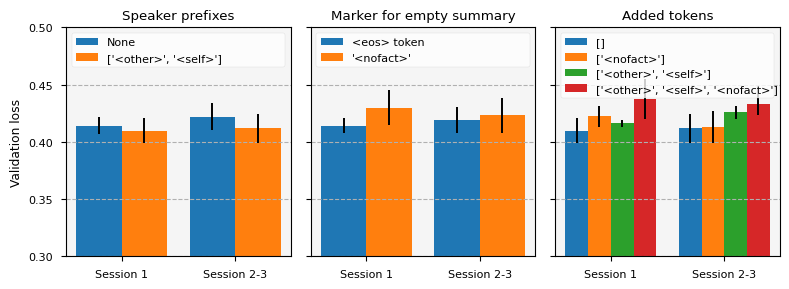

In [120]:

expnames = ['bart_tokens_session1', 'bart_tokens_sessions23']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

# Adjust labels for better plots
df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]

grouplist = ['num_speaker_prefixes', 'config/nofact_token', 'num_add_tokens']
grouptitles = ['Speaker prefixes', 'Marker for empty summary', 'Added tokens']
base_selection = {
    'num_speaker_prefixes': (df['config/nofact_token'] == '') &(df['num_add_tokens'] == 0),
    'config/nofact_token': (df['num_speaker_prefixes'] == 2), 
    'num_add_tokens': (df['num_speaker_prefixes'] == 2)
}
grp_labels = {
    'num_speaker_prefixes': 'config/speaker_prefixes',
    'config/nofact_token': 'config/nofact_token', 
    'num_add_tokens': 'config/add_tokens'
}
exp_titles = {
    'bart_tokens_session1': 'Session 1',
    'bart_tokens_sessions23': 'Session 2-3'
}
with plt.style.context('seaborn-v0_8-paper'):
# with plt.style.context('grayscale'):
    fig, ax = plt.subplots(ncols=len(grouplist), figsize=(8,3), sharey=True)

    for i, grp in enumerate(grouplist):

        print("size of sample: ", len(df[base_selection[grp]]))
        print(grp_labels[grp])
        labels = df[grp_labels[grp]].apply(str).unique()
        # labels = [(l if not l in ['', '[]', '<nofact>'] else ("'<nofact>'" if l == '<nofact>' else 'None')) for l in labels]
        labels = [('<eos> token' if l == '' else ("'<nofact>'" if l == '<nofact>' else ('None' if l == '' else l))) for l in labels]
        print(labels)
        num_labels = len(labels)

        for j, label in enumerate(df[grp].unique()):
            subselection = df[grp] == label
            result_df = df[base_selection[grp] & subselection][['experiment_name', 'valid_loss']].groupby(['experiment_name']).agg(['mean', 'std'])

            x_values = np.arange(len(result_df.index))
            ax[i].bar(
                x=x_values+(0.4 - num_labels * 0.4 + (0.8*j))/num_labels, 
                height=result_df[('valid_loss', 'mean')].values, 
                width=0.8/num_labels, 
                yerr=result_df[('valid_loss', 'std')], 
                label=labels[j]
            )

        ax[i].set_facecolor('whitesmoke')
        ax[i].set_title(grouptitles[i])
        ax[i].set_xticks(x_values)
        ax[i].set_xticklabels(([exp_titles[x] for x in result_df.index]))
        ax[i].grid(which='major', axis='y', linestyle='--')
        ax[i].legend(
            # bbox_to_anchor=(0., 1.02, 1., .102), 
            loc='upper left', 
            mode='expand',
            ncols=1, 
            # borderaxespad=0.
        )
        # ax[i].legend()
        if i == 0:
            ax[i].set_ylim(0.3, 0.5)
            ax[i].set_yticks(np.linspace(0.3, 0.5, 5))
            ax[i].set_ylabel('Validation loss')

    # fig.suptitle("Impact of different choices for speaker_prefixes, nofact_token and add_tokens")
    fig.tight_layout()

In [98]:
for s in plt.style.available:
    print(s)

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn-v0_8
seaborn-v0_8-bright
seaborn-v0_8-colorblind
seaborn-v0_8-dark
seaborn-v0_8-dark-palette
seaborn-v0_8-darkgrid
seaborn-v0_8-deep
seaborn-v0_8-muted
seaborn-v0_8-notebook
seaborn-v0_8-paper
seaborn-v0_8-pastel
seaborn-v0_8-poster
seaborn-v0_8-talk
seaborn-v0_8-ticks
seaborn-v0_8-white
seaborn-v0_8-whitegrid
tableau-colorblind10


### Analyse impact of len_context

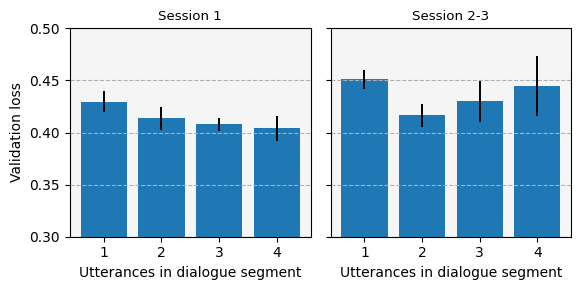

In [122]:
###
### Analyse impact of len_context
###

expnames = ['bart_context_session1', 'bart_context_sessions23'] #, 'bart_context_sessions23_b32']
exptitles = ['Session 1', 'Session 2-3']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(ncols=len(expnames), figsize=(6, 3), sharey=True)
with plt.style.context('seaborn-v0_8-paper'):
    for i, expname in enumerate(expnames):

        selection = (df['experiment_name'] == expname)
        result_df = df[selection].groupby(['config/len_context']).agg({"valid_loss": ['mean', 'std']})['valid_loss']

        x_values = [f"{int(x):d}" for x in result_df.index]
        ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)

        ax[i].set_facecolor('whitesmoke')
        ax[i].set_xlabel("Utterances in dialogue segment")
        ax[i].grid(which='major', axis='y', linestyle='--')
        ax[i].set_title(exptitles[i])
        if i == 0:
            ax[i].set_ylim(0.3, 0.5)
            ax[i].set_ylabel("Validation loss")
        
    # fig.suptitle("Impact of different choices for context length")

    fig.tight_layout()

In [ ]:
expnames = ['bart_context_session1', 'bart_context_sessions23', 'bart_context_sessions23_b32']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(ncols=len(expnames), figsize=(9, 4), sharey=True)

x_values = [f"{int(x):d}" for x in df['config/len_context'].unique()]
seeds = df['config/seed'].unique()

for i, expname in enumerate(expnames):
    for seed in seeds:
        selection = (df['config/seed'] == seed) & (df['experiment_name'] == expname)
        values = df[selection]['valid_loss'].values
        ax[i].plot(x_values[:len(values)], values, label=seed, linestyle='--', linewidth=0.8)

    selection = (df['experiment_name'] == expname)
    result_df = df[selection].groupby(['config/len_context']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    ax[i].plot(x_values, result_df['mean'].values, linewidth=2, c='b')
    ax[i].fill_between(x_values, result_df['mean'].values - result_df['std'].values, result_df['mean'].values + result_df['std'].values, alpha=0.3)
    ax[i].set_xlabel("len_context")
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(expname)
    if i == 0:
        ax[i].set_ylim(0.3, 0.6)
    
fig.suptitle("Impact of different choices for len_context\n(5 trials)")
fig.supylabel("loss")
fig.tight_layout()

In [ ]:
expnames = ['bart_context_session1']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(figsize=(4, 4))

seeds = df['config/seed'].unique()
x_values = [f"{int(x):d}" for x in df['config/len_context'].unique()]

for seed in seeds:
    selection = (df['config/seed'] == seed)
    values = df[selection]['valid_loss'].values
    ax.plot(x_values[:len(values)], values, label=seed)
ax.legend(title='seeds', loc='upper right')
ax.set_xlabel("len_context")
ax.grid(which='major', axis='y', linestyle='--')
    
fig.suptitle("Impact of different choices for len_context")
fig.supylabel("loss")
fig.tight_layout()

### Analyse impact of bart_base

In [ ]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].groupby(['config/bart_base']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    
    ax[i].bar(x=result_df.index, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("bart_base")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

In [ ]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]
basemodels = df["config/bart_base"].unique()

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

x_values = basemodels

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in basemodels
    ]

    ax[i].violinplot(data, showmeans=True)
    
    ax[i].set_xticks(range(1, len(basemodels) + 1), basemodels)
    ax[i].set_xlabel("bart_base")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.supylabel("loss")
fig.tight_layout()

In [ ]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]
basemodels = df["config/bart_base"].unique()

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

x_values = basemodels

for i, s in enumerate(session_list):

    # plot scatterchart with all datapoints
    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    scatter_ax = df[selection].plot.scatter('config/bart_base', 'valid_loss', ax=ax[i])

    # plot corresponding violinplots
    x_ticklabels = [label.get_text() for label in scatter_ax.get_xticklabels()]
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in x_ticklabels
    ]
    ax[i].violinplot(data, positions=range(len(x_ticklabels)), showmeans=False, showextrema=False)

    # add titles, atc
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

In [ ]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]

fig, ax = plt.subplots(figsize=(4, 8))
col = ['tab:blue', 'tab:orange']

for i, s in enumerate(session_list):

    # plot scatter chart with all datapoints
    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    scatter_ax = df[selection].plot.scatter('config/bart_base', 'valid_loss', c=col[i], alpha=0.7, label=f"session {s}", ax=ax)

    # plot corresponding violinplots
    x_ticklabels = [label.get_text() for label in scatter_ax.get_xticklabels()]
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in x_ticklabels
    ]
    ax.violinplot(data, positions=range(len(x_ticklabels)), showmeans=False, showextrema=False)

    # add titles, etc
    ax.tick_params(axis='x', labelrotation = 90)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_ylim(0.35, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

### Analyse impact of clf_loss and lm_loss_factor

In [ ]:
###
### Analyse impact of clf_loss and lm_loss_factor
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].fillna(value="regular").groupby(by=['config/clf_loss'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']

    ax[i].bar(x=result_df.index, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("clf_loss")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for clf_loss")
fig.tight_layout()

In [ ]:
###
### Analyse impact of clf_loss and lm_loss_factor
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') #| (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)

session_list = [1, 3]
fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].fillna(value="None").groupby(by=['config/lm_loss_factor'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']

    x_ticklabels = [f"{x:.2f}" for x in result_df.index]
    bar_ax = ax[i].bar(x=x_ticklabels, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("lm_loss_factor")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for lm_loss_factor")
fig.tight_layout()

In [ ]:

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
df['config/clf_loss'] = df['config/clf_loss'].fillna(value='regular')

variants = ['regular', 'reweighted']
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 4), sharey=True)
col = {'regular': 'tab:blue', 'reweighted': 'tab:orange'}

for i, s in enumerate(session_list):

    for variant in variants:
        selection = (df['config/sessions'] == pd.Series([[s]] * len(df))) & (df['config/clf_loss'] == variant)
        scatter_ax = df[selection].plot.scatter('config/lm_loss_factor', 'valid_loss', c=col[variant], label=variant, alpha=0.5, ax=ax[i])

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    
fig.suptitle("Impact of different choices for lm_loss_factor and clf_loss")
fig.tight_layout()

print(f"Mean of valid_loss, when lm_loss_factor > 0.95: {df[(df['config/lm_loss_factor'] > 0.95)]['valid_loss'].mean():.2f}")
print(f"Mean of valid_loss, when lm_loss_factor < 0.95 and clf_loss == reweighted: {df[(df['config/lm_loss_factor'] < 0.95) & (df['config/clf_loss'] == 'reweighted')]['valid_loss'].mean():.2f}")

In [ ]:
###
### Analyse impact of len_context
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
df['config/clf_loss'] = df['config/clf_loss'].fillna(value='regular')

variants = ['regular', 'reweighted']
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 4), sharey=True)
col = {1: 'tab:blue', 3: 'tab:orange'}

for i, variant in enumerate(variants):

    for s in session_list:
        selection = (df['config/clf_loss'] == pd.Series([variant] * len(df))) & (df['config/sessions'] == pd.Series([[s]] * len(df)))
        scatter_ax = df[selection].plot.scatter('config/lm_loss_factor', 'valid_loss', c=col[s], alpha=0.5, label=f"session {s}", ax=ax[i])
    
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"clf_loss={variant}")
    
fig.suptitle("Impact of different choices for lm_loss_factor and clf_loss")
fig.tight_layout()

## 3. Overview of results, per experiment for GPT2

In [ ]:
exp_selection = (allresults_df['experiment_name'] == 'gpt_bslr')
df = allresults_df[exp_selection].reset_index(drop=True)

config_params = ['config/batch_size', 'config/learning_rate']

fig, axs = plt.subplots(ncols=len(config_params), figsize=(4, 4), sharey=True)
for param, ax in zip(config_params, axs):
    result_df = df.groupby(param, dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    # print(result_df)
    ax.bar(x=result_df.index.astype(str), height=result_df['mean'], yerr=result_df['std'])
    ax.set_title(param.split('/')[1])
    ax.tick_params(axis='x', labelrotation = 90)
    ax.grid(which='major', axis='y', linestyle='--')

fig.suptitle("Impact of parameters for format of input")
fig.tight_layout()

In [ ]:
exp_selection = (allresults_df['experiment_name'] == 'gpt_bslr')
df = allresults_df[exp_selection].reset_index(drop=True)

config_params = ['config/learning_rate', 'config/batch_size']

fig, ax = plt.subplots(figsize=(8, 4))
result_df = df.groupby(config_params).agg({"valid_loss": ['mean', 'std']})['valid_loss']
print(result_df)
ax.bar(x=[str(v) for v in result_df.index.values], height=result_df['mean'], yerr=result_df['std'])
# ax.bar(x=list(range(len(result_df.index))), height=result_df['mean'], yerr=result_df['std'])
# ax.set_title(param.split('/')[1])
ax.tick_params(axis='x', labelrotation = 90)
ax.grid(which='major', axis='y', linestyle='--')
ax.set_ylim(2, 3.5)

fig.suptitle("Impact of various choices for batch_size and learning_rate")
fig.tight_layout()

In [ ]:
exp_selection = (allresults_df['experiment_name'] == 'gpt_context3') | (allresults_df['experiment_name'] == 'gpt_context4')
df = allresults_df[exp_selection].reset_index(drop=True)

config_params = ['config/include_history', 'config/include_persona', 'config/sessionbreak_token', 'config/add_tokens', 'config/context_option', 'config/token_option']
df['config/add_tokens'] = ['None' if x is None else str(x) for x in df['config/add_tokens']]
df['config/context_option'] = df['config/context_option'].astype(int)
df['config/token_option'] = df['config/token_option'].astype(int)

fig, axs = plt.subplots(ncols=len(config_params), figsize=(12, 6), sharey=True)
for param, ax in zip(config_params, axs):
    result_df = df.groupby(param, dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    # print(result_df)
    ax.bar(x=result_df.index.astype(str), height=result_df['mean'], yerr=result_df['std'])
    ax.set_title(param.split('/')[1])
    ax.tick_params(axis='x', labelrotation = 90)
    ax.grid(which='major', axis='y', linestyle='--')

fig.suptitle("Impact of parameters for format of input")
fig.tight_layout()

In [ ]:
token_config = {
    "sessionbreak_token": {0: None, 1:'<session>', 2:'<session>', 3: '<session>', 4:None},
    "add_tokens":{0:None, 1:['<other>', '<self>'], 2:['<other>', '<self>', '<session>'], 3:None, 4:['<other>', '<self>']},
}
context_config = {
    "include_history": {0:False, 1:False, 2:True, 3:True, 4:True},
    "include_persona": {0:True, 1:True, 2:False, 3:True, 4:True},
    "persona_selector": {0:None, 1:'preprocessed:trained_base_reweighted_bart', 2:None, 3:None, 4:'preprocessed:trained_base_reweighted_bart'},
}
token_config_df = pd.DataFrame(token_config)
context_config_df = pd.DataFrame(context_config)

exp_selection = (allresults_df['experiment_name'] == 'gpt_context3') | (allresults_df['experiment_name'] == 'gpt_context4')
df = allresults_df[exp_selection].reset_index(drop=True)
df['config/add_tokens'] = ['None' if x is None else str(x) for x in df['config/add_tokens']]
df['config/context_option'] = df['config/context_option'].astype(int)
df['config/token_option'] = df['config/token_option'].astype(int)

fig, ax = plt.subplots(figsize=(30, 5))

result_df = df.groupby(['config/context_option', 'config/token_option'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']
result_df = result_df.join(context_config_df, on='config/context_option', how='left')
result_df = result_df.join(token_config_df, on='config/token_option', how='left')
result_df = result_df.sort_values(by='mean', ascending=False)
# print(result_df[])
result_df['persona_selector'] = ['' if x is None else x.split('_')[-1] for x in result_df['persona_selector']]

y_labels = result_df.index.values
# print(y_labels)
ax.barh(y=list(range(len(result_df))), width=result_df['mean'], label='average (n=5)')
ax.errorbar(y=list(range(len(result_df))),  x=result_df['mean'], xerr=result_df['std'], c='r', fmt='none', label='std')

ax.set_yticks([]) #(list(range(len(result_df))))
ax.set_yticklabels([])
ax.set_ylim(-0.5, len(y_labels) - 0.5)
ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlim(result_df['mean'].min() * 0.9)
ax.set_xlabel("Validation loss")
ax.set_title("Impact of various configuration choices on validation loss")

columns = list(context_config.keys()) + list(token_config.keys())
ax_table = ax.table(cellText=result_df[columns].values[::-1],
    colLabels=["History", "Personas", "Selector", "Sessionbreak", "Added tokens"],
    colWidths = [1, 1, 1, 1.5, 3],
    cellLoc='center',
    bbox=[-1, 0, 0.95, 1.04],
    # fontsize=50,
    # loc='left'
)
ax.legend()
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(8)

# fig.suptitle("Impact of various configuration choices on validation loss")
fig.tight_layout()


In [ ]:
token_config_df = pd.DataFrame(token_config)
context_config_df = pd.DataFrame(context_config)

In [ ]:
exp_selection = (allresults_df['experiment_name'] == 'gpt_context3') | (allresults_df['experiment_name'] == 'gpt_context4')
df = allresults_df[exp_selection].reset_index(drop=True)

cols = ['config/include_history', 'config/include_persona', 'config/sessionbreak_token', 'config/add_tokens', 'config/persona_selector']
groupings = [['config/include_history'], ['config/include_persona'], ['config/sessionbreak_token'], ['config/add_tokens'], ['config/context_option'], ['config/token_option']]
df['config/add_tokens'] = ['None' if x is None else str(x) for x in df['config/add_tokens']]

grouplist2 = ['config/context_option', 'config/token_option']

df[cols + grouplist2+ ['valid_loss']].groupby(grouplist2, dropna=False).agg({"valid_loss": ['mean', 'std']})
# df[cols + grouplist2 + ['config/seed', 'valid_loss']].to_csv("gpt_context3.csv", sep='\t')


In [ ]:
exp_selection = (allresults_df['experiment_name'] == 'gpt_context3')  | (allresults_df['experiment_name'] == 'gpt_context4')
df = allresults_df[exp_selection].reset_index(drop=True)

groupings = [['config/include_history'], ['config/include_persona'], ['config/sessionbreak_token'], ['config/add_tokens']]
# df['added_tokens'] = ['None' if x is None else ' '.join(x) for x in df['config/add_tokens']]
df['added_tokens'] = ['None' if x is None else str(x) for x in df['config/add_tokens']]
grouplist = groupings[3]
result_df = df.groupby(['added_tokens'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']
print(result_df)


## OLDER CHARTS

In [ ]:
batch_size = 64
learning_rate = 1e-5

fig, ax = plt.subplots(figsize=(4,6))

for result in result_grid:
    if result.config['batch_size'] == batch_size and result.config['learning_rate'] == learning_rate:
        result.metrics_dataframe.plot("training_iteration", "valid_loss", ax=ax, label=result.config['seed'])

In [ ]:
best_result = result_grid.get_best_result()
best_result.metrics_dataframe.plot("training_iteration", "valid_loss")

In [ ]:
df['valid_acc'].max()

In [ ]:
df.groupby(by=grouplist, dropna=False)['valid_acc', 'time_total_s', 'training_iteration'].agg({'valid_acc': ['max', 'mean', 'std', 'count'], 'time_total_s': ['mean'], 'training_iteration': ['mean']})

In [ ]:
## OLD RAY_RESULTS FROM TUNING PREFIXBERT

ray_results_dir = "/Users/FrankVerhoef/Programming/PEX/checkpoints/ray_results/"
experiments = [
    {
        'exp_file': "train_with_args_2023-03-29_23-24-42", 
        'comment': "Tune PrefixBert with speaker prefixes <self>, <other>",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/prefix_aggr', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_10-12-15", 
        'comment': "Tune PrefixBert without speaker prefixes",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-21-13", 
        'comment': "Tune Bart, without speaker prefixes",
        'grouplist': ['config/learning_rate', 'config/batch_size']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-55-16", 
        'comment': "Tune PrefixBart"
    },
]

exp=experiments[2]
exp_name = exp['exp_file']
grouplist = exp['grouplist']
restored_tuner = tune.Tuner.restore(ray_results_dir + exp_name)
result_grid = restored_tuner.get_results()
len(result_grid)

In [ ]:
df_grouped = df.groupby(by=grouplist, dropna=False)

In [ ]:
df_mean = df_grouped['valid_acc'].agg(['mean']).unstack()['mean']
df_mean

In [ ]:
cols = df_mean.columns
df_mean.columns = [f"{c[0]}, {c[1]}" for c in cols]
df_mean.columns

In [ ]:
# df_mean.plot.bar(figsize=(10,3))
df_mean.plot.bar()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Batch size")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
# plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.xlabel("Learning rate")
plt.title(exp['comment'])# + "\nwith various model configurations and training parameters")

In [ ]:
# df_time = df_grouped['time_total_s'].agg(['mean']).unstack().unstack()
df_time = df_grouped['time_total_s'].agg(['mean']).unstack()['mean']
df_time

In [ ]:
# df_time['mean'].plot.bar(figsize=(10,3))
df_time.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.ylabel("Time to convergence\n(seconds)")
plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.title(exp['comment'] + "\nwith various model configurations and training parameters")

In [ ]:
# Get the result with the maximum test set `mean_accuracy`
best_result = result_grid.get_best_result()
best_result.config

In [ ]:
best_result.metrics_dataframe.plot("training_iteration", "valid_acc")

In [ ]:
df.groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_size'])['valid_acc', 'time_total_s'].agg(['mean', 'std'])

In [ ]:
df[df['config/prefix_size'] == 5].groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_aggr'])['valid_acc'].max()